In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from scipy.signal import lombscargle
from scipy.stats import normaltest, ks_2samp

from lightkurve import KeplerLightCurveFile
from PyAstronomy.modelSuite.XTran.forTrans import MandelAgolLC

from transit_utils import bindata, transit_duration, supersample_time
from variable_eclipses_utils import *

from BEER_curve import BEER_curve

import time as tm

from scipy.integrate import simps

from astropy import units as u
from astropy import constants as const
from astropy.modeling.blackbody import blackbody_lambda

K76 = Kepler76_params()

BoiseState_blue = '#0033A0'
BoiseState_orange = '#D64309'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Kepler-76 b's blackbody equilibrium temp

# As of 2018 Oct 21, using Analyzing_...LM, these are the best-fit values:
a_over_Rs = 5.09403323e+00
p = 8.48133077e-02
E = 8.66138711e-05 #eclipse depth
Tp = np.sqrt(1./a_over_Rs/np.sqrt(2))*K76.Ts
print(K76.Ts, Tp)

(6300.0, 2347.21117246978)


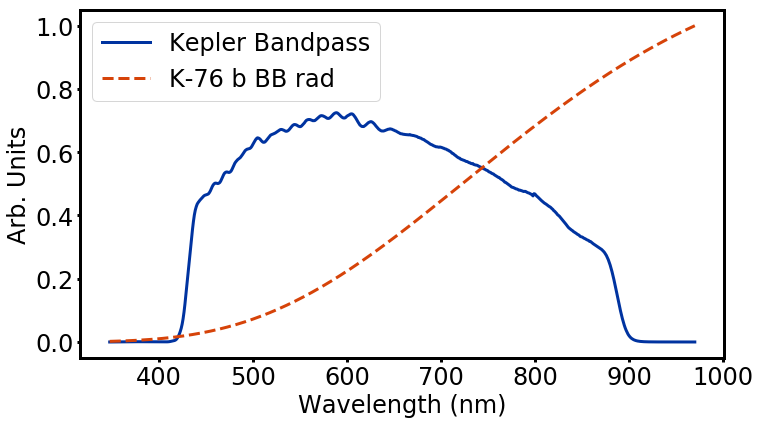

In [15]:
fig = plt.figure(figsize=(6.*16/9, 6))
ax = fig.add_subplot(111)

# Read in Kepler response function
Kepler_func_filename = '../eclipse_estimates/kepler_response_hires1.txt'

Kepler_func = np.genfromtxt(Kepler_func_filename, names='Wavelength, Transmission')
ax.plot(Kepler_func['Wavelength'], Kepler_func['Transmission'], lw=3, color=BoiseState_blue, label='Kepler Bandpass')

pl_BBrad = blackbody_lambda(Kepler_func['Wavelength']*10, Tp)
ax.plot(Kepler_func['Wavelength'], pl_BBrad/np.max(pl_BBrad), lw=3, ls='--', color=BoiseState_orange, 
        label='K-76 b BB rad')

ax.legend(loc='best', fontsize=24)

ax.tick_params(labelsize=24, width=3)

ax.set_xlabel('Wavelength (nm)', fontsize=24)
ax.set_ylabel('Arb. Units', fontsize=24)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

plt.tight_layout()
fig.savefig('Kepler-band_BB-rad_Kepler76b_BB_rad.png', dpi=500)

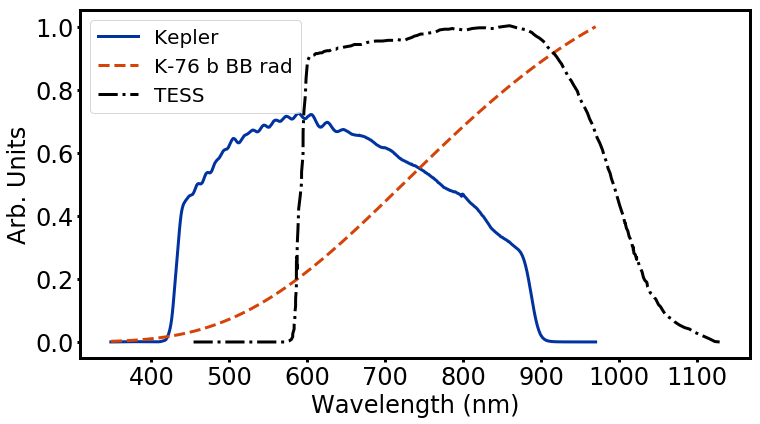

In [27]:
fig = plt.figure(figsize=(6.*16/9, 6))
ax = fig.add_subplot(111)

# Read in Kepler response function
Kepler_func_filename = '../eclipse_estimates/kepler_response_hires1.txt'
Kepler_func = np.genfromtxt(Kepler_func_filename, names='Wavelength, Transmission')
ax.plot(Kepler_func['Wavelength'], Kepler_func['Transmission'], lw=3, color=BoiseState_blue, label='Kepler')

pl_BBrad = blackbody_lambda(Kepler_func['Wavelength']*10, Tp)
ax.plot(Kepler_func['Wavelength'], pl_BBrad/np.max(pl_BBrad), lw=3, ls='--', color=BoiseState_orange, 
        label='K-76 b BB rad')

TESS_func_filename = '../eclipse_estimates/tess-response-function-v1.0.csv'
TESS_func = np.genfromtxt(TESS_func_filename, comments='#', names=True, delimiter=',')
ax.plot(TESS_func['Wavelength'], TESS_func['Transmission'], lw=3, ls='-.', color='k', label='TESS')

ax.legend(loc='upper left', fontsize=20)

ax.tick_params(labelsize=24, width=3)

ax.set_xlabel('Wavelength (nm)', fontsize=24)
ax.set_ylabel('Arb. Units', fontsize=24)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

plt.tight_layout()
fig.savefig('Kepler-band_TESS-band_BB-rad_Kepler76b_BB_rad.png', dpi=500)

2827.75157533
2178.36637397
3078.95173768


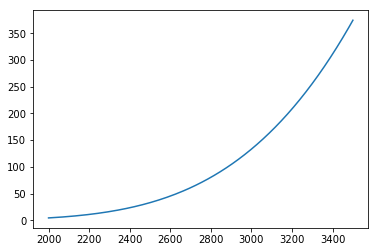

In [34]:
temps = np.linspace(2000., 3500., 150)
Kep_st_sig = simps(blackbody_lambda(Kepler_func['Wavelength']*10, K76.Ts)*Kepler_func['Transmission'], 
                   x=Kepler_func['Wavelength']*10)


Kep_pl_sigs = np.zeros_like(temps)
for i in range(len(temps)):
    Kep_pl_sigs[i] = simps(blackbody_lambda(Kepler_func['Wavelength']*10, temps[i])*Kepler_func['Transmission'], 
                   x=Kepler_func['Wavelength']*10)
    
    
eclipse_depths = p**2*Kep_pl_sigs/Kep_st_sig
plt.plot(temps, eclipse_depths*1e6)

print(np.interp(E, eclipse_depths, temps))

# min and max 3-sigma eclipse depths
print(np.interp(10e-6, eclipse_depths, temps))
print(np.interp(160e-6, eclipse_depths, temps))